In [21]:
import tensorflow as tf 
import numpy as np
from scipy.ndimage import binary_dilation
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
!pip install neurokit2
import neurokit2 as nk
import wfdb 



Defaulting to user installation because normal site-packages is not writeable


In [16]:

# Define the custom focal loss function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        CE = -tf.keras.backend.log(pt)
        FL = tf.keras.backend.pow(1 - pt, gamma) * CE
        return tf.keras.backend.mean(alpha * FL)
    return focal_loss_fixed

# Load the model with the custom loss function
model = keras.models.load_model("training.keras", custom_objects={'focal_loss_fixed': focal_loss(gamma=2., alpha=0.25)})

In [17]:
import matplotlib.pyplot as plt

def plot_ecg_results(signal, labels, predictions, sample_index=0):
    """
    Plots ECG signal, ground truth labels, and model predictions.

    Args:
    - signal (numpy array): The ECG signals, shape should be (num_samples, num_time_steps).
    - labels (numpy array): The ground truth labels, shape should be (num_samples, num_time_steps).
    - predictions (numpy array): The model predictions, shape should be (num_samples, num_time_steps).
    - sample_index (int): The index of the sample to plot.
    """
    # Select the sample to plot
    ecg_signal = signal[sample_index]
    ground_truth = labels[sample_index]
    model_predictions = predictions[sample_index]
    
    # Plotting
    plt.figure(figsize=(15, 6))
    
    # Plot ECG Signal
    plt.subplot(3, 1, 1)
    plt.plot(ecg_signal, color='black')
    plt.title('ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    # Plot Ground Truth Labels
    plt.subplot(3, 1, 2)
    plt.plot(ground_truth, color='red')
    plt.title('Ground Truth Labels (R-peaks)')
    plt.xlabel('Time')
    plt.ylabel('Label')
    
    # Plot Model Predictions
    plt.subplot(3, 1, 3)
    plt.plot(model_predictions, color='blue')
    plt.title('Model Predictions (R-peaks)')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    
    plt.tight_layout()
    plt.show()


#### Testing model's prediction on afib signals from various datasets online 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


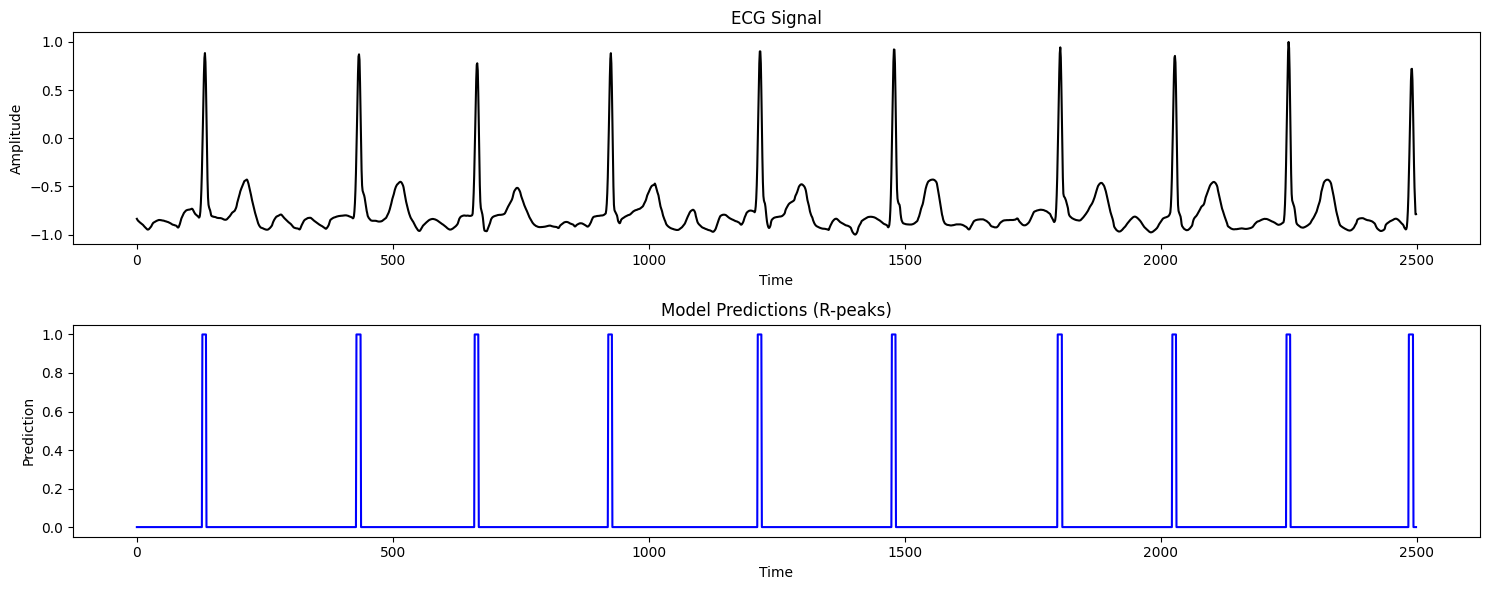

In [24]:

def load_mat_file(file_path):
    """Load .mat file and extract ECG signals."""
    data = loadmat(file_path)
    ecg_signal = data['val'].flatten()  
    return ecg_signal

def preprocess_data(ecg_signal):
    """Preprocess data to match training format."""
    # Normalize the signal to match training preprocessing
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).reshape(1, -1)
    if scaled_signal.shape[1] != 2500:
        raise ValueError(f"Expected signal length 2500, got {scaled_signal.shape[1]}")
    return scaled_signal.reshape(1, 2500, 1)  

def plot_ecg_results(signal, predictions):
    """Plot ECG signal and model predictions."""
    plt.figure(figsize=(15, 6))
    
    # Plot ECG Signal
    plt.subplot(2, 1, 1)
    plt.plot(signal[0], color='black')
    plt.title('ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    # Plot Model Predictions
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0], color='blue')
    plt.title('Model Predictions (R-peaks)')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    
    plt.tight_layout()
    plt.show()


# Load and preprocess .mat data
file_path = 'test_data/A00004.mat' 
ecg_signal = load_mat_file(file_path)
# Ensure signal length matches the model input shape
preprocessed_signal = preprocess_data(ecg_signal[6500:9000])

# Predict using the trained model
predictions = model.predict(preprocessed_signal)
y_pred_binary = (predictions > 0.5).astype(int) 

# Post-process predictions
y_pred_processed = binary_dilation(y_pred_binary.reshape(predictions.shape[0], predictions.shape[1]), structure=np.ones((1, 5)))

# Plot results
plot_ecg_results(preprocessed_signal, y_pred_processed)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


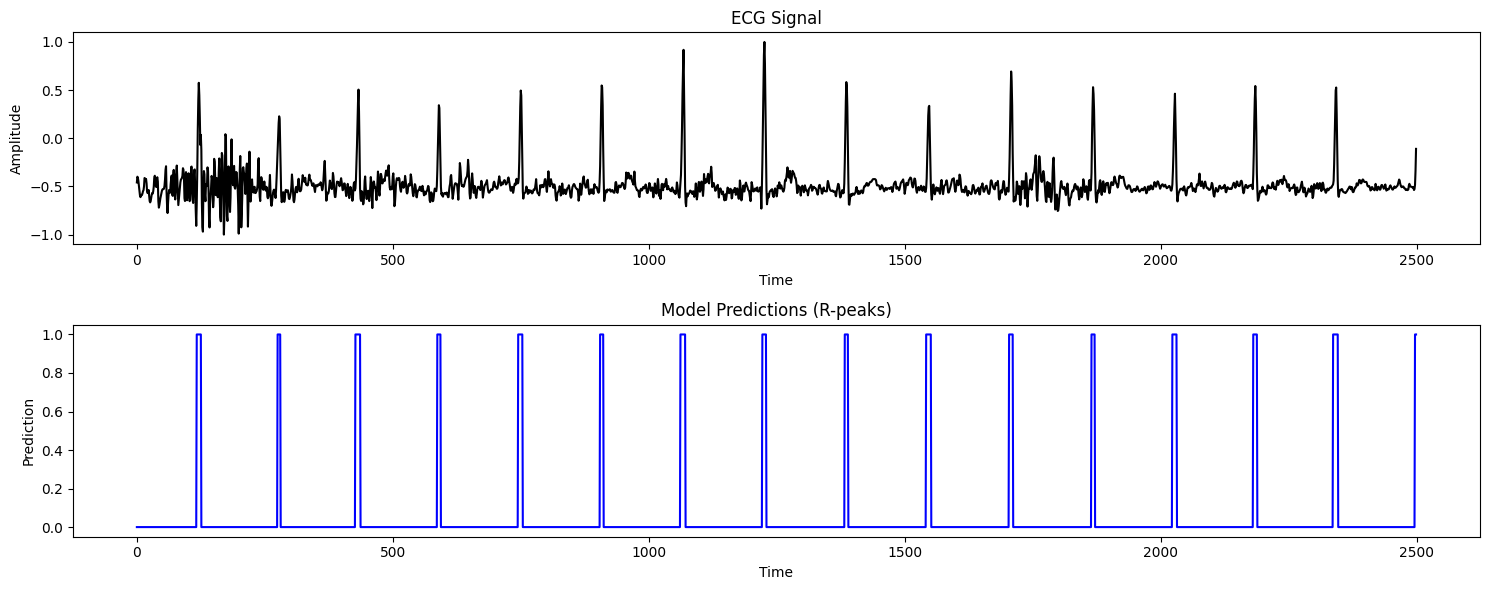

In [27]:
#Sample 003 taken from shdb dataset SHDB-AF: a Japanese Holter ECG database of atrial fibrillation:
# FS = 200hz

s,_ = (wfdb.io.rdsamp("test_data/japan/003")) #reading sample
ecg = s[:,0]
preprocessed_signal = preprocess_data(ecg[20500:23000])
# Predict using the trained model
predictions = model.predict(preprocessed_signal)
y_pred_binary = (predictions > 0.4).astype(int) 

# Post-process predictions
y_pred_processed = binary_dilation(y_pred_binary.reshape(predictions.shape[0], predictions.shape[1]),
                                   structure=np.ones((1, 5)))
# Plot results
plot_ecg_results(preprocessed_signal, y_pred_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


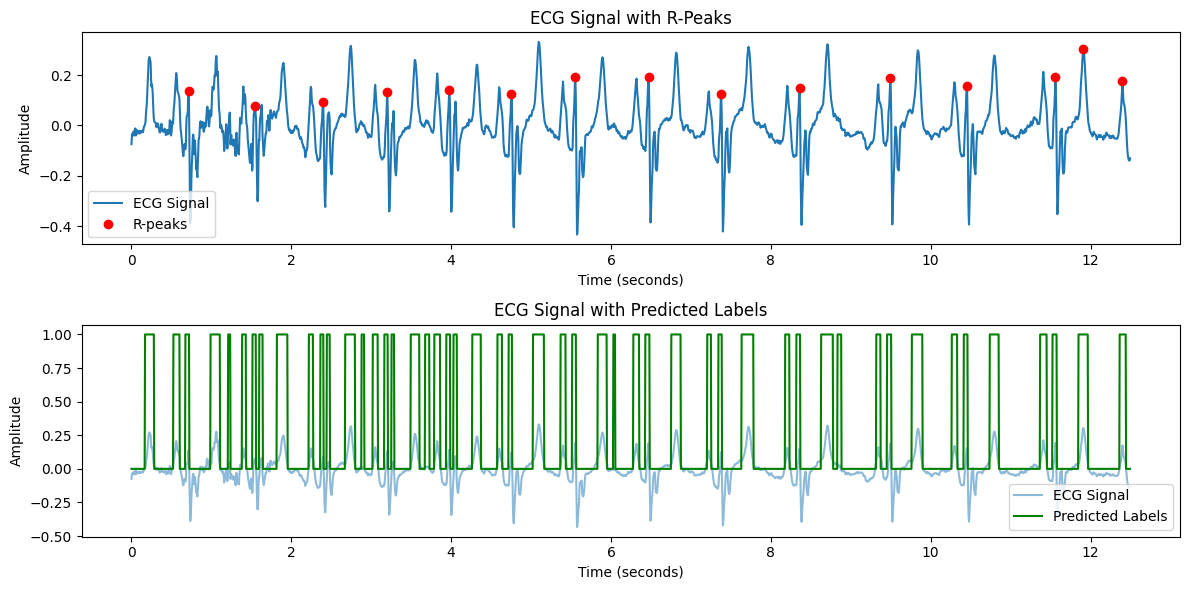

In [29]:
#Sample 009 taken from shdb dataset SHDB-AF: a Japanese Holter ECG database of atrial fibrillation:
# FS = 200hz
#Channel = 2

# I have tried to detect r_peaks using neurokit2 package and then compare the predictions with my model here

# Load the ECG signal
s, _ = wfdb.io.rdsamp("test_data/japan/009") 
ecg_signal = s[:, 1][15000:17500]  # Extracting segment of Channel 2

# Detect R-peaks
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=200)
r = rpeaks['ECG_R_Peaks']

preprocessed_signal = preprocess_data(ecg_signal)
predictions = model.predict(preprocessed_signal)
y_pred_binary = (predictions > 0.5).astype(int)  # Model didn't predict well for threshold 0.5

y_pred_processed = binary_dilation(y_pred_binary.reshape(predictions.shape[0], predictions.shape[1]),structure=np.ones((1, 5)))
y_pred_processed = y_pred_processed.flatten()
time_axis = np.arange(len(ecg_signal)) / 200

# Plot 1: ECG Signal with R-peaks
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time_axis, ecg_signal, label='ECG Signal')
plt.plot(time_axis[r], ecg_signal[r], 'ro', label='R-peaks')  # Red dots for R-peaks
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with R-Peaks')
plt.legend()

# Plot 2: Predicted Labels
plt.subplot(2, 1, 2)
plt.plot(time_axis, ecg_signal, label='ECG Signal', alpha=0.5)
plt.plot(time_axis, y_pred_processed, 'g', label='Predicted Labels')  # Plot predictions
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Predicted Labels')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Works better if I increase the threshold to 0.7 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


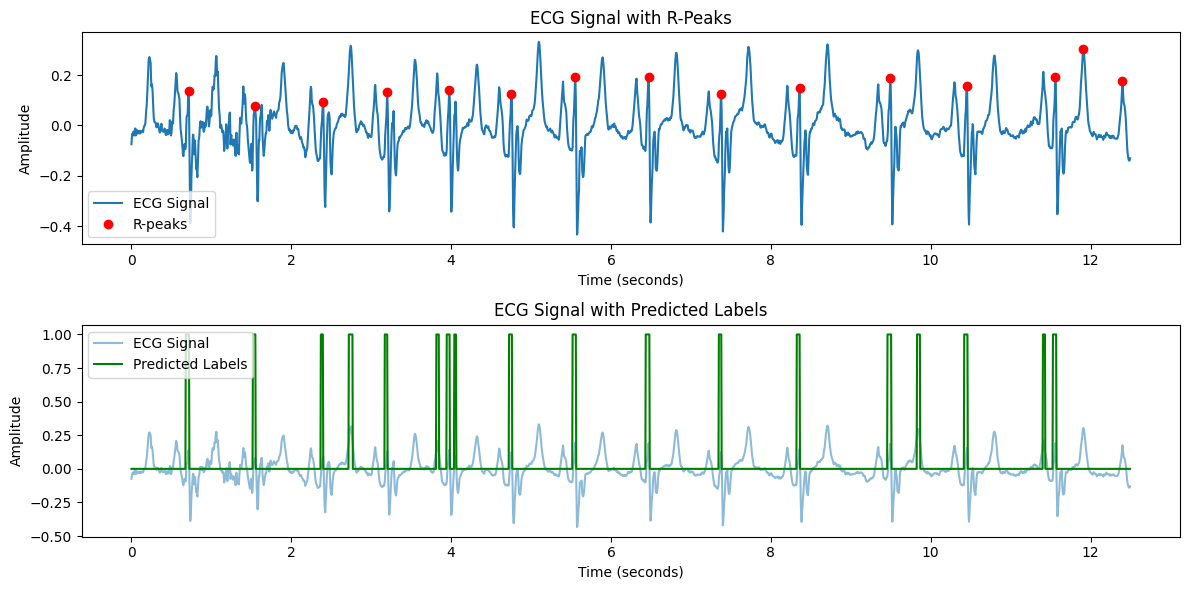

In [30]:
#Sample 009 taken from shdb dataset SHDB-AF: a Japanese Holter ECG database of atrial fibrillation:
# FS = 200hz
#Channel = 2

# I have tried to detect r_peaks using neurokit2 package and then compare the predictions with my model here

# Load the ECG signal
s, _ = wfdb.io.rdsamp("test_data/japan/009") 
ecg_signal = s[:, 1][15000:17500]  # Extracting segment of Channel 2

# Detect R-peaks
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=200)
r = rpeaks['ECG_R_Peaks']

preprocessed_signal = preprocess_data(ecg_signal)
predictions = model.predict(preprocessed_signal)
y_pred_binary = (predictions > 0.7).astype(int)  # Model didn't predict well for threshold 0.5

y_pred_processed = binary_dilation(y_pred_binary.reshape(predictions.shape[0], predictions.shape[1]),structure=np.ones((1, 5)))
y_pred_processed = y_pred_processed.flatten()
time_axis = np.arange(len(ecg_signal)) / 200

# Plot 1: ECG Signal with R-peaks
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time_axis, ecg_signal, label='ECG Signal')
plt.plot(time_axis[r], ecg_signal[r], 'ro', label='R-peaks')  # Red dots for R-peaks
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with R-Peaks')
plt.legend()

# Plot 2: Predicted Labels
plt.subplot(2, 1, 2)
plt.plot(time_axis, ecg_signal, label='ECG Signal', alpha=0.5)
plt.plot(time_axis, y_pred_processed, 'g', label='Predicted Labels')  # Plot predictions
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Predicted Labels')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
